In [159]:
## Reloading packages
%load_ext autoreload
%autoreload 2

## Adding 'FDS profiling package'
import sys
sys.path.insert(0, '/Users/harsh/Desktop/DATA_SCIENCE/PandasProfiling/')

import warnings
warnings.filterwarnings("ignore")

## Packages
import requests
import io

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from fds_profiling.visualisation.network import networkplot
from fds_profiling.model.variable_types import get_df_var_types

from profile_report import profiling

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
# describe_numeric_1d(df["Age"])

##### Titanic dataset

In [161]:
s = requests.get("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv").content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

## Metrics
#### TODO: space problem in metric name
def count_(df):
    return df

def metric_1(df):
    return df["Survived"].sum()

def metric_2(df):
    return df["Survived"].count()

total_metrics = [("metric_1", metric_1), ("metric_2", metric_2)]

In [162]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


#### Profiling

In [164]:
profiling(dataframe=df,
          target_variable = "Pclass",
          user_metrics=total_metrics,
          output_file="titanic_profiling.html",
#           title="Titanic Profiling"
         )

In [140]:
import seaborn as sns
from fds_profiling.visualisation.image_encoding import hex_to_rgb, plot_360_n0sc0pe

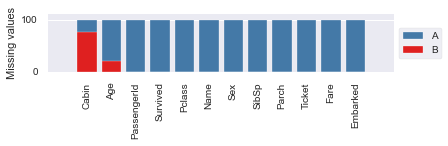

In [148]:
dataframe = df

row_count = dataframe.shape[0]

## missing: column wise
missing_column_df = dataframe.isnull().sum()
missing_column_df = pd.DataFrame(missing_column_df, columns=["Missing values"])

missing_column_df["values"] = row_count
missing_column_df = missing_column_df.apply(lambda x: 100*round(x/row_count, 2)).astype(int)
missing_column_df.sort_values("Missing values", ascending=False, inplace=True)


## bar plot
sns.set_style("darkgrid")
## plot 1 - "total" - (top) series
sns.barplot(x=missing_column_df.index, y="values", data=missing_column_df, color="#337ab7", label="A")

## plot 2 - overlay - "bottom" series
sns.barplot(x=missing_column_df.index, y="Missing values", data=missing_column_df, color="red", label="B")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation="90")
plt.subplots_adjust(left=0.1, right=0.9, top=0.7, bottom=0.5)
plt.margins(.1, 0.1)

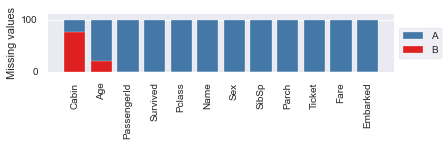

#### Network x

In [8]:
import networkx as nx
from fds_profiling.model.variable_types import get_df_var_types

In [9]:
column_types = get_df_var_types(df)
# column_types

In [10]:
## associations df
from fds_profiling.model.associations import associations
assn_df = associations(df, column_types)
assn_df["assn"] = abs(assn_df["association"])

## filter
assn_df = assn_df[assn_df["assn"] >= .01]

In [49]:
# networkplot(df, column_types, assn_df)

In [50]:
assn_df.head(2)

,col_a,association,col_b,type_,assn
110,Fare,0.59,Pclass,NUM-CAT,0.59
33,Pclass,0.59,Fare,CAT-NUM,0.59


In [51]:
## 1 step: drawing edges
G = nx.from_pandas_edgelist(assn_df,
                            source='col_a', target='col_b',
                            edge_attr=["assn", "type_"],
                            create_using=nx.DiGraph())

In [52]:
corr_edges = [(u,v) for (u,v,d) in G.edges(data=True) if d['type_'] == "NUM-NUM"]
corr_ratio_edges = [(u,v) for (u,v,d) in G.edges(data=True) if d['type_'] in ("NUM-CAT", "CAT-NUM")]
theil_edges = [(u,v) for (u,v,d) in G.edges(data=True) if d['type_'] in ("CAT-CAT")]

In [53]:
## 2 step: size and color attribute of node

## size attirbute
size_df = assn_df.groupby("col_a", as_index=False)["assn"].sum().rename(columns={"assn":"size"})
## - normalizing
max_size = size_df["size"].max()
size_df["size"] = size_df["size"]/max_size

##
for i in list(G.nodes()):
    G.nodes[i]['size'] = size_df[size_df['col_a']==i]['size'].values[0]
    
    if (column_types[i] == "BOOL"):
        G.nodes[i]['color'] = "#c03d3e"
    elif (column_types[i] == "CAT"):
        G.nodes[i]['color'] = "#3a923a"
    elif (column_types[i] == "NUM"):
        G.nodes[i]['color'] = "#337ab7"
    else:
        G.nodes[i]['color'] = "blue"

In [54]:
## node shape: https://matplotlib.org/api/markers_api.html#module-matplotlib.markers

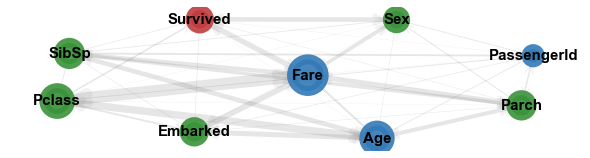

In [127]:
# fixing the size of the figure 
plt.figure(figsize =(10, 4)) 
  
# ## color, size, width
node_color = [nx.get_node_attributes(G, 'color')[v] for v in G] 
node_size = [1000*nx.get_node_attributes(G, 'size')[v] for v in G]  
edge_width = [20*G[u][v]['assn'] for u, v in G.edges()] 

## layout
pos=nx.spring_layout(G, iterations=50)

# node labels
nx.draw_networkx_labels(G, pos, font_size=15, font_family='sans-serif',with_labels = True, font_color="#000000", font_weight="bold")

## nodes
nx.draw_networkx_nodes(G, pos=pos, node_color = node_color, node_size = node_size, node_shape = "o", alpha=0.9,linewidths=10)
 
# edges
nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.1, edge_color="grey", arrowsize=20, arrowstyle='->')

plt.axis('off') 
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.7, bottom=0.2)

In [90]:
assn_df[assn_df["type_"] == "CAT-CAT"]

,col_a,association,col_b,type_,assn
16,Survived,0.23,Sex,CAT-CAT,0.23
49,Sex,0.23,Survived,CAT-CAT,0.23
79,SibSp,0.18,Parch,CAT-CAT,0.18
90,Parch,0.15,SibSp,CAT-CAT,0.15
35,Pclass,0.10,Embarked,CAT-CAT,0.10
25,Pclass,0.09,Survived,CAT-CAT,0.09
134,Embarked,0.07,Pclass,CAT-CAT,0.07
14,Survived,0.06,Pclass,CAT-CAT,0.06
88,Parch,0.05,Sex,CAT-CAT,0.05
76,SibSp,0.04,Sex,CAT-CAT,0.04


In [181]:
assn_df[(assn_df["type_"] == "CAT-CAT") & ((assn_df["col_a"] == "Pclass") | (assn_df["col_b"] == "Pclass"))]

,col_a,association,col_b,type_,assn
35,Pclass,0.10,Embarked,CAT-CAT,0.10
25,Pclass,0.09,Survived,CAT-CAT,0.09
134,Embarked,0.07,Pclass,CAT-CAT,0.07
14,Survived,0.06,Pclass,CAT-CAT,0.06
74,SibSp,0.04,Pclass,CAT-CAT,0.04
30,Pclass,0.04,SibSp,CAT-CAT,0.04
86,Parch,0.01,Pclass,CAT-CAT,0.01
50,Sex,0.01,Pclass,CAT-CAT,0.01
31,Pclass,0.01,Parch,CAT-CAT,0.01
28,Pclass,0.01,Sex,CAT-CAT,0.01


In [123]:
assn_df.head(20)

,col_a,association,col_b,type_,assn
110,Fare,0.59,Pclass,NUM-CAT,0.59
33,Pclass,0.59,Fare,CAT-NUM,0.59
62,Age,0.37,Pclass,NUM-CAT,0.37
29,Pclass,0.37,Age,CAT-NUM,0.37
141,Embarked,0.28,Fare,CAT-NUM,0.28
119,Fare,0.28,Embarked,NUM-CAT,0.28
21,Survived,0.26,Fare,CAT-NUM,0.26
93,Parch,0.26,Fare,CAT-NUM,0.26
109,Fare,0.26,Survived,NUM-CAT,0.26
115,Fare,0.26,Parch,NUM-CAT,0.26


In [91]:
# Graph with Custom nodes:
plt.figure(figsize=(12, 12))
nx.draw(G,
        with_labels=True,
        ,
        
        # node customizations
        node_size=1500,
        node_color="orange",
        node_shape="o",
        alpha=0.4,
        linewidths=5,
        
        # label customization
        font_size=18,
        font_color="#333333",
        font_weight="bold",
        
        # edge customization
        width=5,
        edge_color="orange",
        style="solid"
       )

plt.show()

SyntaxError: invalid syntax (<ipython-input-91-920290b22b92>, line 5)

In [371]:
# Using pandas dataframe
G = nx.from_pandas_edgelist(associations_df[associations_df["association"] > .1], "col_a", 'col_b', edge_attr="association")

# ## Creating node
for column in df.columns:
    G.add_node(column)

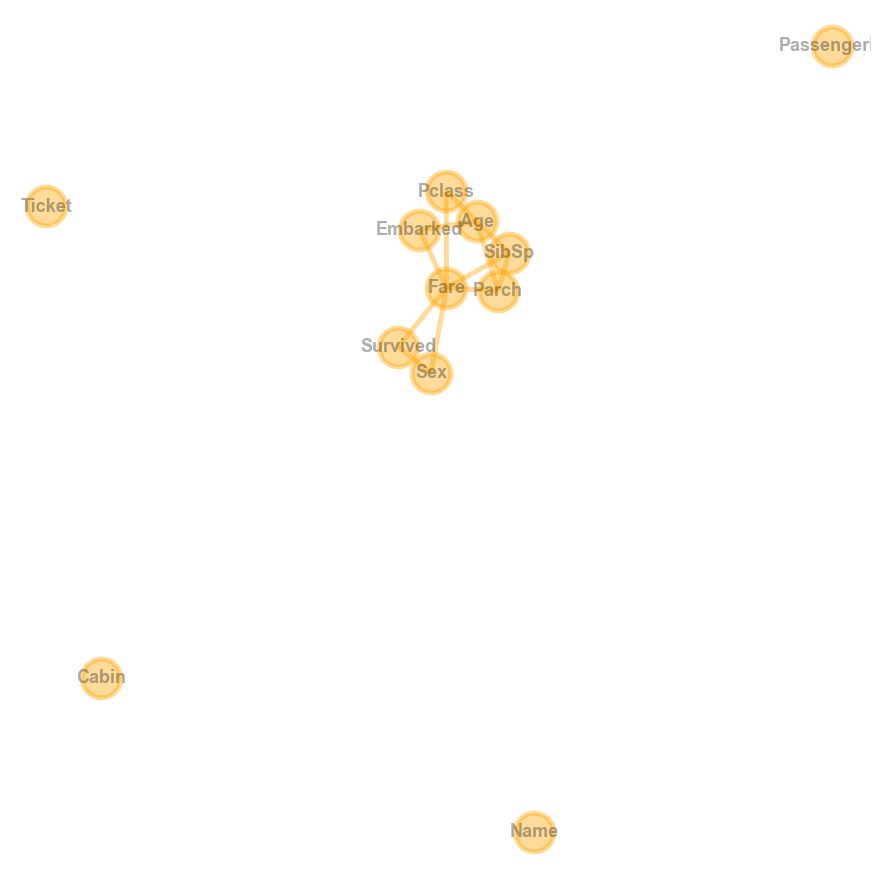

In [375]:
# Graph with Custom nodes:
plt.figure(figsize=(12, 12))
nx.draw(G,
        with_labels=True,
        pos=nx.spring_layout(G, iterations=50),
        
        # node customizations
        node_size=1500,
        node_color="orange",
        node_shape="o",
        alpha=0.4,
        linewidths=5,
        
        # label customization
        font_size=18,
        font_color="#333333",
        font_weight="bold",
        
        # edge customization
        width=5,
        edge_color="orange",
        style="solid"
       )

plt.show()

In [376]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 12))

# # 1. Create the graph
# G = nx.from_pandas_edgelist(associations_df.head(5), "col_a", 'col_b', edge_attr="association")

# # ## Creating node
# for column in df.columns:
#     G.add_node(column)

# # 2. Create a layout for our nodes 
# layout = nx.spring_layout(G, iterations=50)    

# # G = nx.from_pandas_edgelist(df,'number','contactnumber', edge_attr='callduration')
# durations = [i['association']*10 for i in dict(G.edges).values()]
# labels = [i for i in dict(G.nodes).keys()]
# labels = {i:i for i in dict(G.nodes).keys()}

# fig, ax = plt.subplots(figsize=(12,5))
# pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, layout, ax = ax, labels=True, node_size=400)
# nx.draw_networkx_edges(G, layout, edge_color='#FF0000')
# nx.draw_networkx_labels(G, layout, labels, ax=ax)


# plt.axis('off')
# plt.show()

In [377]:
# # G = nx.from_pandas_edgelist(df,'number','contactnumber', edge_attr='callduration')
# durations = [i['association']*10 for i in dict(G.edges).values()]
# labels = [i for i in dict(G.nodes).keys()]
# labels = {i:i for i in dict(G.nodes).keys()}

# fig, ax = plt.subplots(figsize=(12,5))
# pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos, ax = ax, labels=True, node_size=400)
# nx.draw_networkx_edges(G, pos, width=durations, ax=ax)
# nx.draw_networkx_labels(G, pos, labels, ax=ax)


# plt.axis('off')
# plt.show()

In [231]:
# import networkx library
import networkx as nx

In [239]:
corr = df.iloc[:,0:4].corr()

links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# correlation
threshold = -0.2

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['value'] >= threshold ) & (links['var1'] != links['var2']) ]

In [241]:
links_filtered.head(2)

,var1,var2,value
1,PassengerId,Survived,-0.005007
2,PassengerId,Pclass,-0.035144


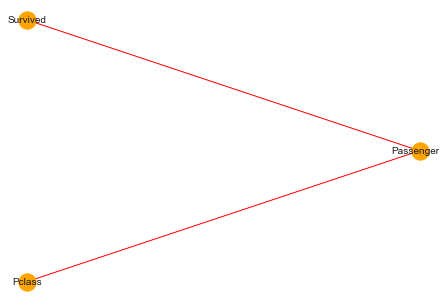

In [242]:
# Transform it in a links data frame (3 columns only):



 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
 
# Plot the network
nx.draw_circular(G, with_labels=True, node_color='orange', node_size=300, edge_color='red', linewidths=1, font_size=10)

In [263]:
df = pd.DataFrame({'ID':[1,2,3,4,5,6], 
                   'First Name':['Felix', 'Jean', 'James', 'Daphne', 'James', 'Peter'], 
                   'Family Name': ['Revert', 'Durand', 'Wright', 'Hull', 'Conrad', 'Donovan'],
                   'Phone number': ['+33 6 12 34 56 78', '+33 7 00 00 00 00', '+33 6 12 34 56 78', '+33 6 99 99 99 99', '+852 0123 4567', '+852 0123 4567'],
                   'Email': ['felix.revert@gmail.com', 'jean.durand@gmail.com', 'j.custom@gmail.com', pd.np.nan, 'j.custom@gmail.com', pd.np.nan]})

/Users/harsh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """


In [264]:
df.head(2)

,ID,First Name,Family Name,Phone number,Email
0,1,Felix,Revert,+33 6 12 34 56 78,felix.revert@gmail.com
1,2,Jean,Durand,+33 7 00 00 00 00,jean.durand@gmail.com


In [265]:
column_edge = 'Phone number'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() # select columns, remove NaN

# To create connections between people who have the same number,
# join data with itself on the 'ID' column.
data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

In [266]:
# By joining the data with itself, people will have a connection with themselves.
# Remove self connections, to keep only connected people who are different.
d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]
    
# To avoid counting twice the connections (person 1 connected to person 2 and person 2 connected to person 1)
# we force the first ID to be "lower" then ID_2
d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [267]:
import networkx as nx

G = nx.from_pandas_edgelist(df=d, source=column_ID, target=column_ID+'_2', edge_attr=column_edge)

G.add_nodes_from(nodes_for_adding=df.ID.tolist())

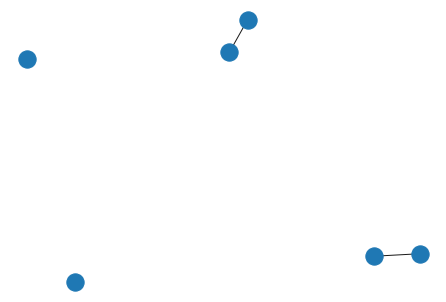

In [268]:
nx.draw(G)

In [1]:
#no